In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline
# Scikit-learn for Machine Learning Models & Metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV  # splitting datasets, cross-validation, and hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier  # the Random Forest classification model
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score)  # various evaluation metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder  # data scaling and encoding
from sklearn.inspection import permutation_importance  # feature importancer tuning?
from sklearn.feature_selection import SelectFromModel 
from tensorflow import keras  
from tensorflow.keras.models import Sequential  # linear stack of layers in neural networks
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, Flatten, BatchNormalization, Activation  # neural network layers
from tensorflow.keras.regularizers import l1_l2  # L1 and L2 regularization
from tensorflow.keras.optimizers import Adam  # Optimizer for training neural networks

In [2]:
#Import Dataset
dataset=pd.read_csv('combined99.csv')
d1= pd.read_csv('Device 1.csv')
d2= pd.read_csv('Device 2.csv')
d3= pd.read_csv('Device 3.csv')
d4= pd.read_csv('Device 4.csv')
d5= pd.read_csv('Device 5.csv')
d6= pd.read_csv('Device 6.csv')
d7= pd.read_csv('Device 7.csv')
d8= pd.read_csv('Device 8.csv')
d9= pd.read_csv('Device 9.csv')

In [3]:
# Brief description for the dataset
print("Dataset Shape:", dataset.shape) # Dataset.shape is a function that returns a tuple (number of rows, number of columns)
dataset.info()   # Datatype
dataset.describe()
dataset.columns
dataset.head()

Dataset Shape: (80000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MI_dir_L1_mean         80000 non-null  float64
 1   MI_dir_L0.1_weight     80000 non-null  float64
 2   MI_dir_L0.1_mean       80000 non-null  float64
 3   MI_dir_L0.01_weight    80000 non-null  float64
 4   MI_dir_L0.01_mean      80000 non-null  float64
 5   MI_dir_L0.01_variance  80000 non-null  float64
 6   H_L0.1_weight          80000 non-null  float64
 7   H_L0.1_mean            80000 non-null  float64
 8   H_L0.1_variance        80000 non-null  float64
 9   H_L0.01_weight         80000 non-null  float64
 10  H_L0.01_mean           80000 non-null  float64
 11  H_L0.01_variance       80000 non-null  float64
 12  HH_jit_L5_mean         80000 non-null  float64
 13  HH_jit_L3_mean         80000 non-null  float64
 14  HH_jit_L1_mean         8000

,MI_dir_L1_mean,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_jit_L5_mean,HH_jit_L3_mean,HH_jit_L1_mean,HH_jit_L0.1_weight,HH_jit_L0.1_mean,HH_jit_L0.01_mean,LABEL
0,60.000000,1.000000,60.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.505913e+09,1.505913e+09,1.505913e+09,1.000000,1.505913e+09,1.505913e+09,1
1,60.000000,1.000000,60.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.505659e+09,1.505659e+09,1.505659e+09,1.000000,1.505659e+09,1.505659e+09,0
2,74.102299,4020.903767,74.136810,5354.681027,74.129441,25.244821,4020.903767,74.136810,27.663711,5354.681027,74.129441,25.244821,1.527283e-03,7.375614e-03,1.874286e+03,4009.923449,1.892384e+05,2.633603e+05,1
3,90.000000,1.290099,87.976936,24.205671,86.189461,3837.105793,1.290099,87.976936,114.964766,24.205671,86.189461,3837.105793,4.042346e+01,4.042346e+01,4.042346e+01,1.066412,4.030084e+01,8.843831e+06,0
4,74.102723,4100.898655,74.135829,5541.152768,74.129025,24.424220,4100.898655,74.135829,26.446198,5541.152768,74.129025,24.424220,1.813740e-03,4.445933e-03,1.453555e+03,4089.271445,1.799947e+05,2.537420e+05,1


In [4]:
def analyze_and_clean_data(datasets):
    for idx in range(9):
        print(f"Analysis for Dataset {idx+1}")
        # Calculate missing values for each column in the dataset
        missing_values = dataset.isna().sum()
        # Calculate infinite values for each column in the dataset
        numeric_cols = dataset.select_dtypes(include=[np.number]).columns
        infinite_values = np.isinf(dataset[numeric_cols]).sum()

        # Calculate percentages
        total_values = len(dataset)
        missing_percentages = missing_values / total_values
        infinite_percentages = infinite_values / total_values

        # Set thresholds
        MISSING_VALUES_COLUMN_THRESHOLD = 0.5 
        INFINITE_VALUES_THRESHOLD = 0.1        
        MISSING_VALUES_ROW_THRESHOLD = 0.5
        # Determine columns to drop
        columns_to_drop = missing_percentages[(missing_percentages > MISSING_VALUES_COLUMN_THRESHOLD) | (infinite_percentages > INFINITE_VALUES_THRESHOLD)].index

        # Dataframe of two columns (Missing & Infinite Percentages) and replace any missing value with zero
        columns_to_drop_dataset = pd.DataFrame({'Missing Percentage': missing_percentages[columns_to_drop], 'Infinite Percentage': infinite_percentages[columns_to_drop]}).fillna(0)

        # Identify columns for imputation
        moderate_missing_cols = missing_percentages[(missing_percentages > 0) & (missing_percentages <= MISSING_VALUES_COLUMN_THRESHOLD)]
        moderate_infinite_cols = infinite_percentages[(infinite_percentages > 0) & (infinite_percentages <= INFINITE_VALUES_THRESHOLD)]

        # Combine the columns using union of indices
        columns_for_imputation_set = set(moderate_missing_cols.index).union(set(moderate_infinite_cols.index))
        # Convert the set to a list for DataFrame creation
        columns_for_imputation_list = list(columns_for_imputation_set)

        # Create DataFrame for columns to impute
        columns_for_imputation_dataset = pd.DataFrame(index=columns_for_imputation_list)
        columns_for_imputation_dataset['Missing Percentage'] = missing_percentages[columns_for_imputation_dataset.index]
        columns_for_imputation_dataset['Infinite Percentage'] = infinite_percentages[columns_for_imputation_dataset.index]
        columns_for_imputation_dataset.fillna(0, inplace=True)  # Fill NaN with 0 for clarity

        # Analyze rows for missing values
        rows_to_drop_dataset = pd.DataFrame(dataset.isna().sum(axis=1) / dataset.shape[1], columns=['Missing Values Proportion'])
        rows_to_drop_dataset = rows_to_drop_dataset[rows_to_drop_dataset['Missing Values Proportion'] > MISSING_VALUES_ROW_THRESHOLD]

        # Print results
        print(f"\nColumns with High Missing/Infinite Values (To Drop): {len(columns_to_drop_dataset)}")
        if not(columns_to_drop_dataset.empty):
            print(columns_to_drop_dataset)

        print(f"\nColumns with Moderate Missing/Infinite Values (Consider Imputation): {len(columns_for_imputation_dataset)}")
        if not(columns_for_imputation_dataset.empty):
            print(columns_for_imputation_dataset)

        print(f"\nTotal Number of Rows to Drop: {len(rows_to_drop_dataset)}")
        if not(rows_to_drop_dataset.empty):
            print(rows_to_drop_dataset)
        
        # Detailed count for missing and infinite values
        missing_values_count = missing_values[missing_values > 0]
        infinite_values_count = infinite_values[infinite_values > 0]
        missing_values_dataset = pd.DataFrame(missing_values_count, columns=['Missing Values Count'])
        infinite_values_dataset = pd.DataFrame(infinite_values_count, columns=['Infinite Values Count'])

        if not missing_values_dataset.empty:
            print("\nMissing Values Count Before Imputation:\n", missing_values_dataset)
        else:
            print("\nNo missing values detected.")

        if not infinite_values_dataset.empty:
            print("\nInfinite Values Count in Numeric Columns Before Imputation:\n", infinite_values_dataset)
        else:
            print("\nNo infinite values detected.")
        print("\n" + "="*40 + "\n")

# Assuming datasets is a list of dataframes
datasets = [d1, d2, d3, d4, d5, d6, d7, d8, d9]
analyze_and_clean_data(datasets)


Analysis for Dataset 1

Columns with High Missing/Infinite Values (To Drop): 0

Columns with Moderate Missing/Infinite Values (Consider Imputation): 0

Total Number of Rows to Drop: 0

No missing values detected.

No infinite values detected.


Analysis for Dataset 2

Columns with High Missing/Infinite Values (To Drop): 0

Columns with Moderate Missing/Infinite Values (Consider Imputation): 0

Total Number of Rows to Drop: 0

No missing values detected.

No infinite values detected.


Analysis for Dataset 3

Columns with High Missing/Infinite Values (To Drop): 0

Columns with Moderate Missing/Infinite Values (Consider Imputation): 0

Total Number of Rows to Drop: 0

No missing values detected.

No infinite values detected.


Analysis for Dataset 4

Columns with High Missing/Infinite Values (To Drop): 0

Columns with Moderate Missing/Infinite Values (Consider Imputation): 0

Total Number of Rows to Drop: 0

No missing values detected.

No infinite values detected.


Analysis for Dataset

In [5]:
def plot_correlation_heatmap(dataset, figsize=(48, 32), cmap='coolwarm', title="Correlation Matrix"):
    # Selecting numeric columns and handling missing values
    numeric_dataset = dataset.select_dtypes(include=[np.number])
    
    # Feature names (column names of DataFrame)
    feature_names = numeric_dataset.columns

    # Compute the correlation matrix
    numeric_data = numeric_dataset.to_numpy()
    corr_matrix = np.corrcoef(numeric_data, rowvar=False)

    # Creating heatmap
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap,
                      square=True, linewidths=.5, cbar_kws={"shrink": .5},
                      xticklabels=feature_names, yticklabels=feature_names)  # Feature names as labels
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

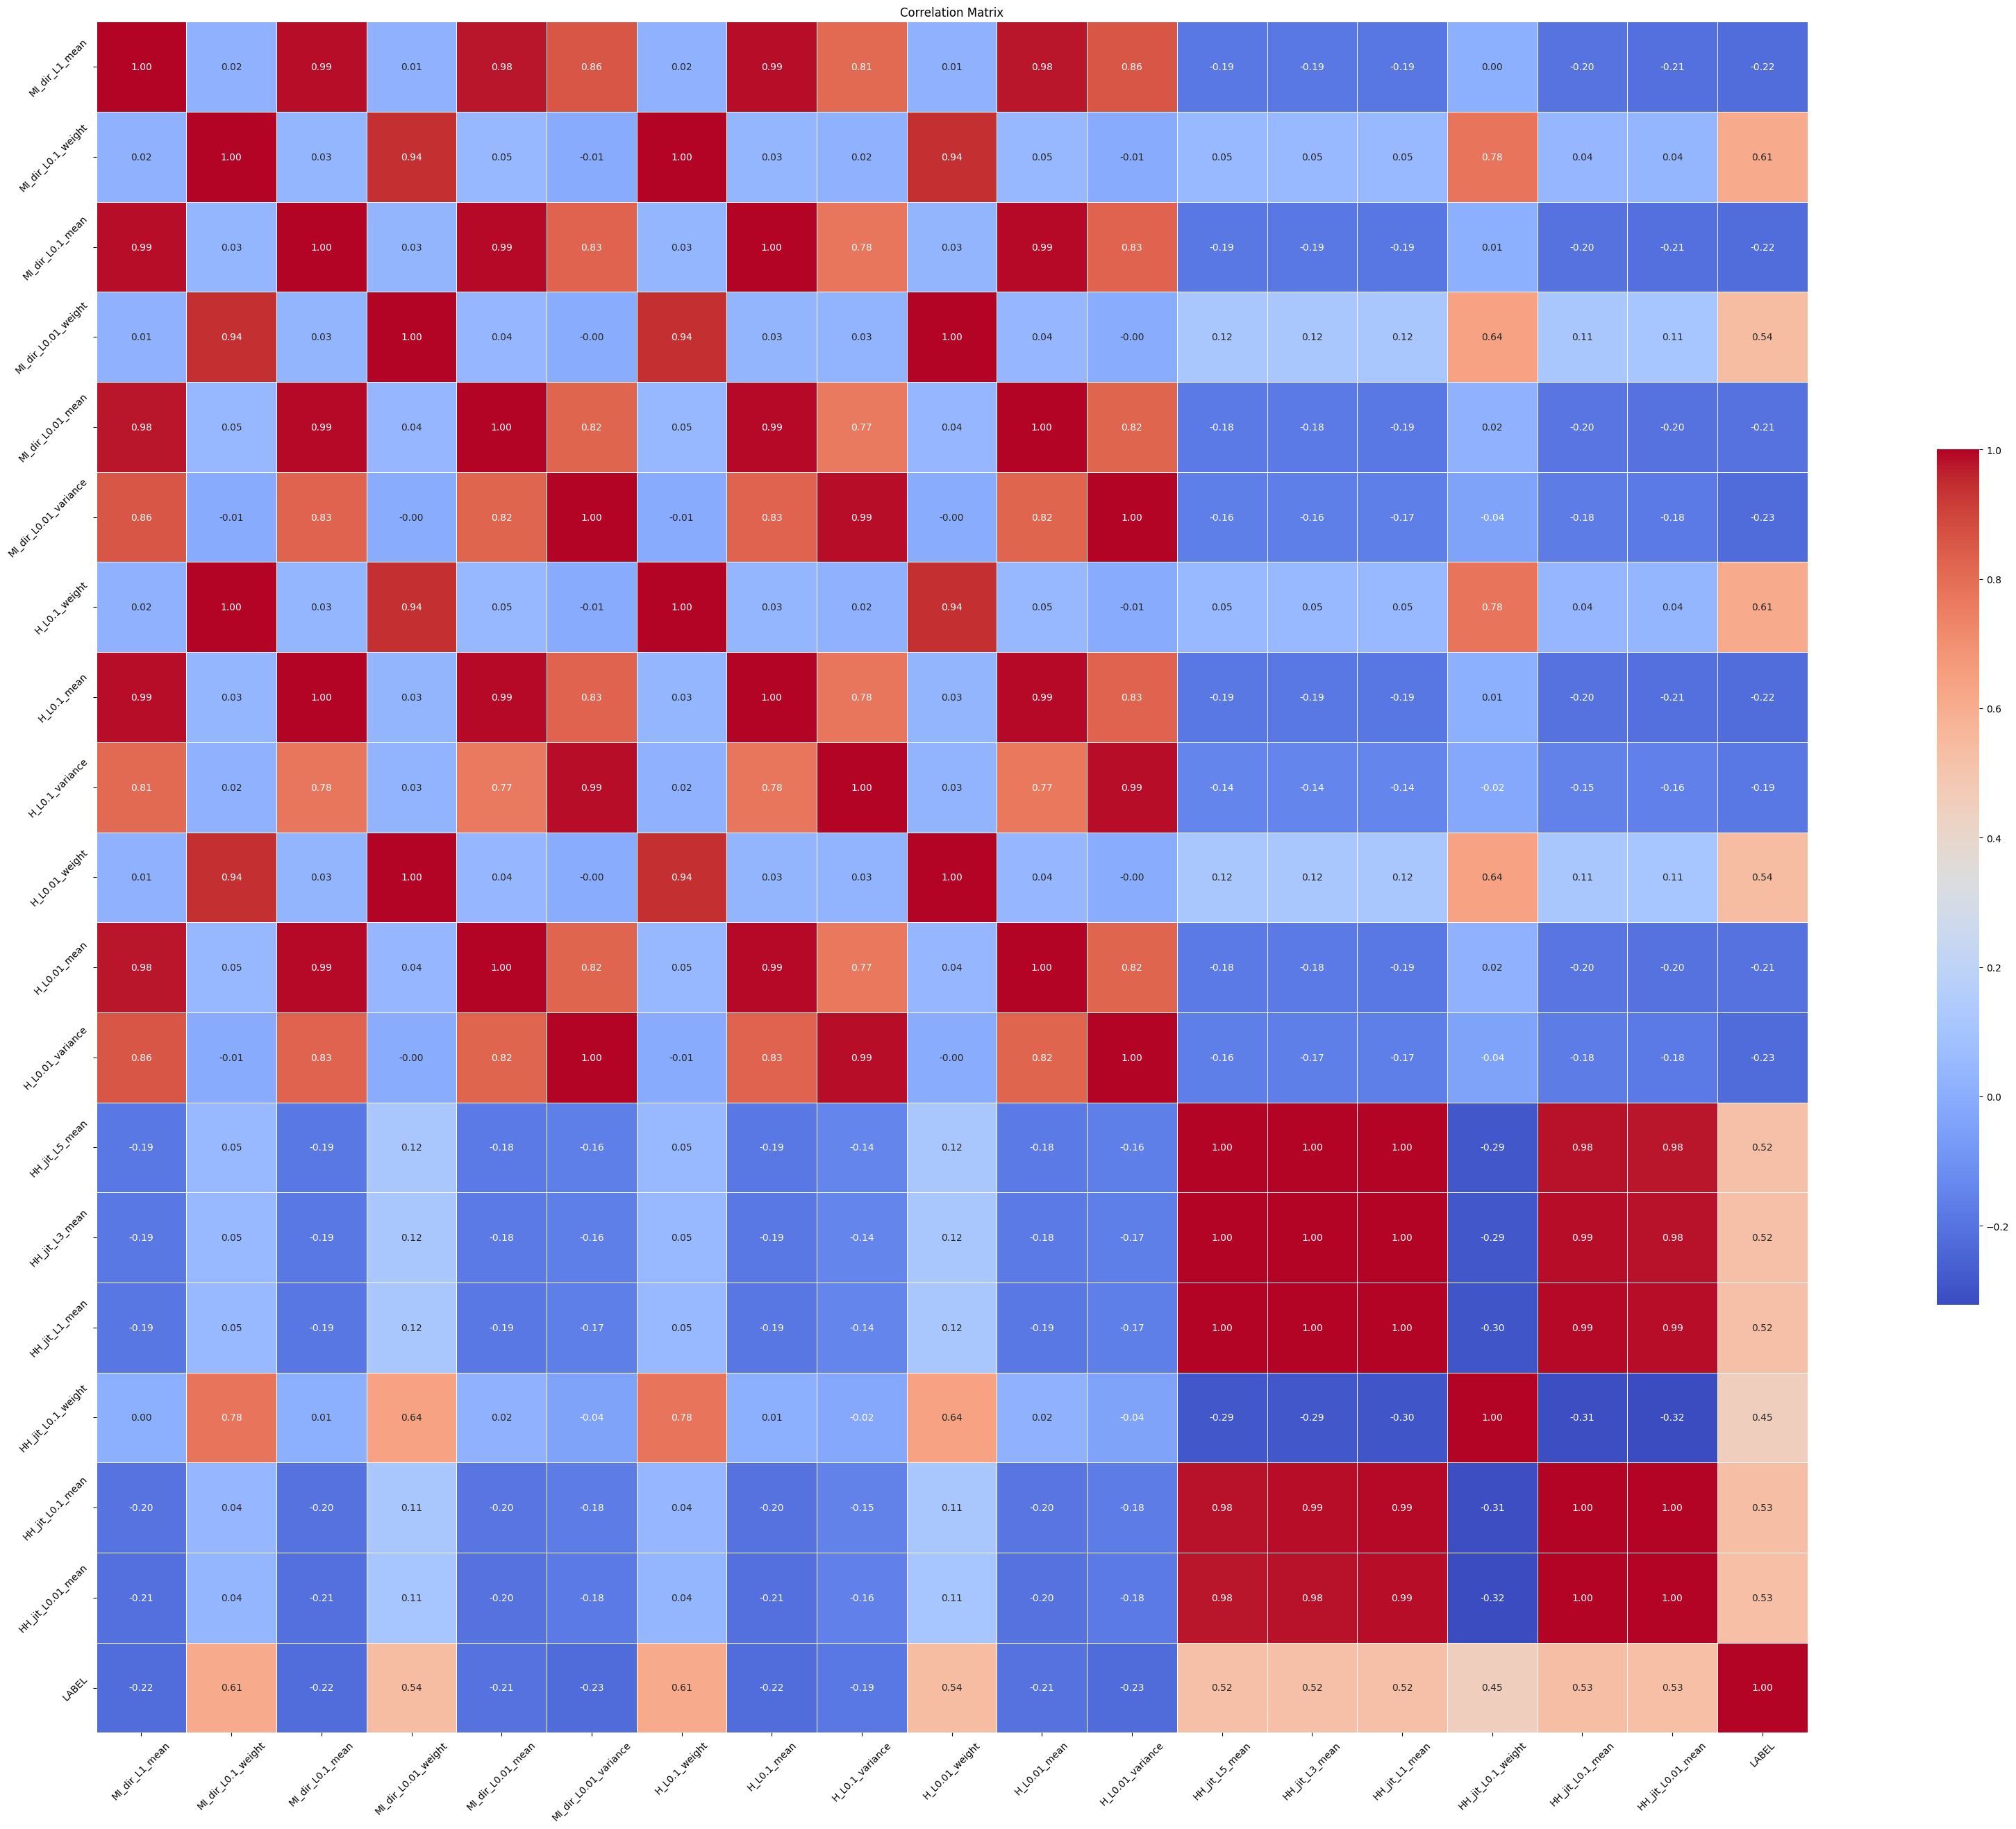

In [6]:
plot_correlation_heatmap(dataset)

In [7]:
pd.set_option('display.max_columns', None)

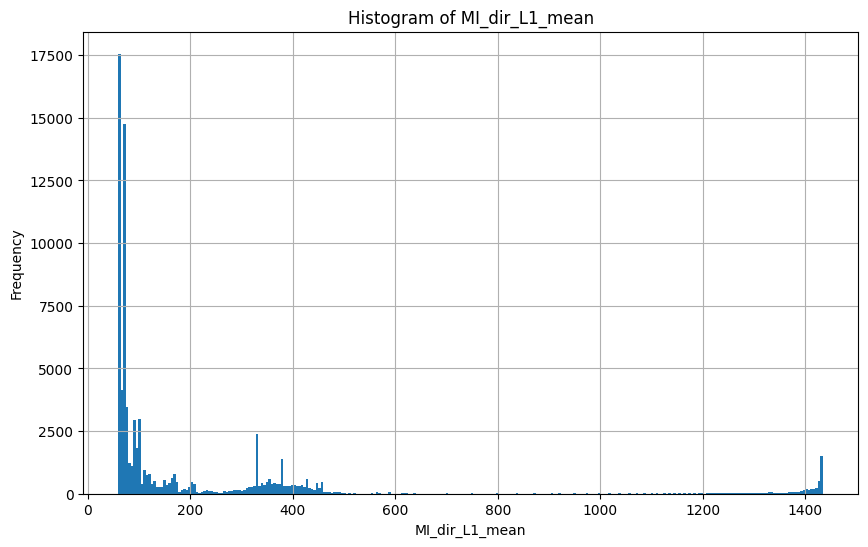

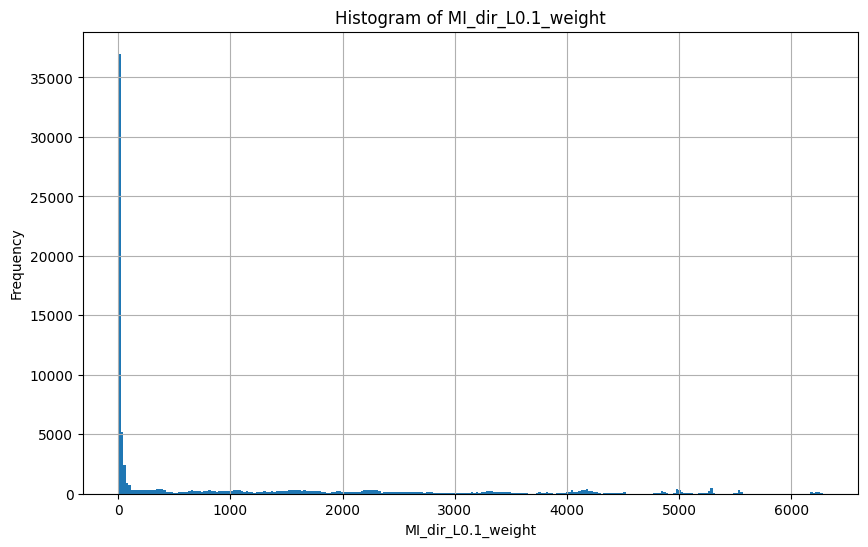

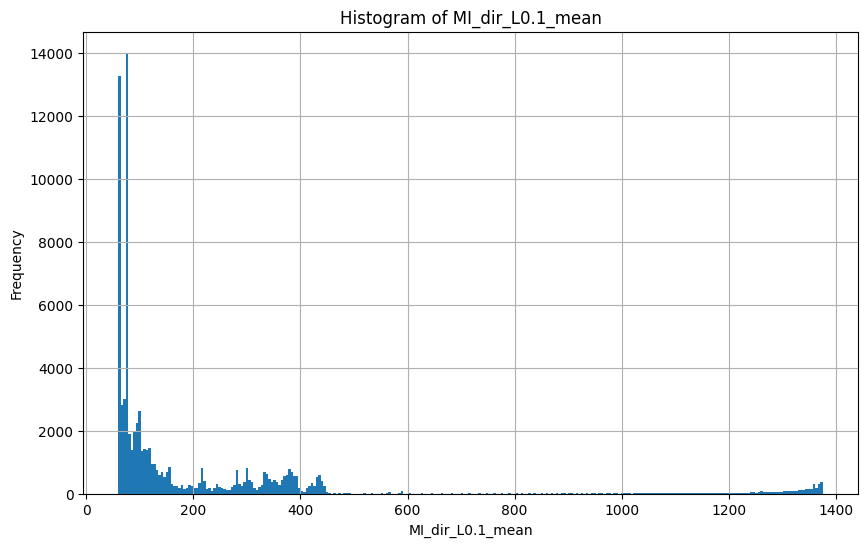

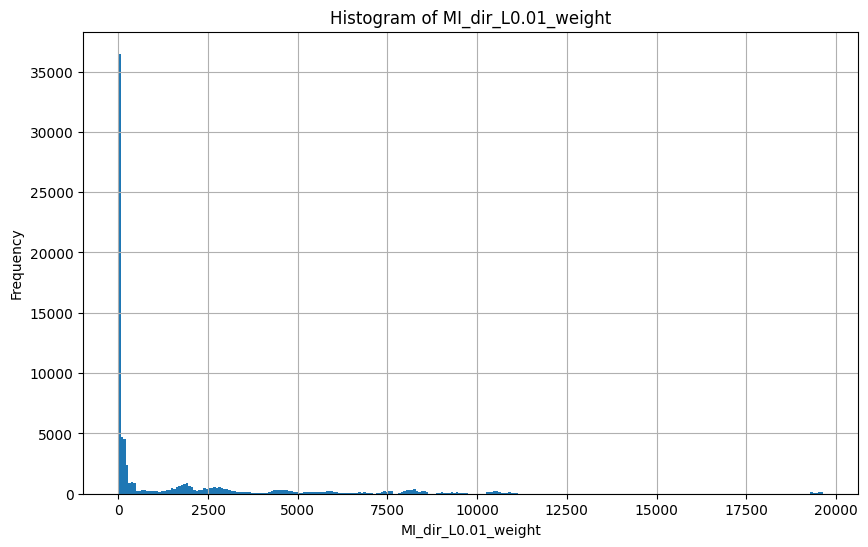

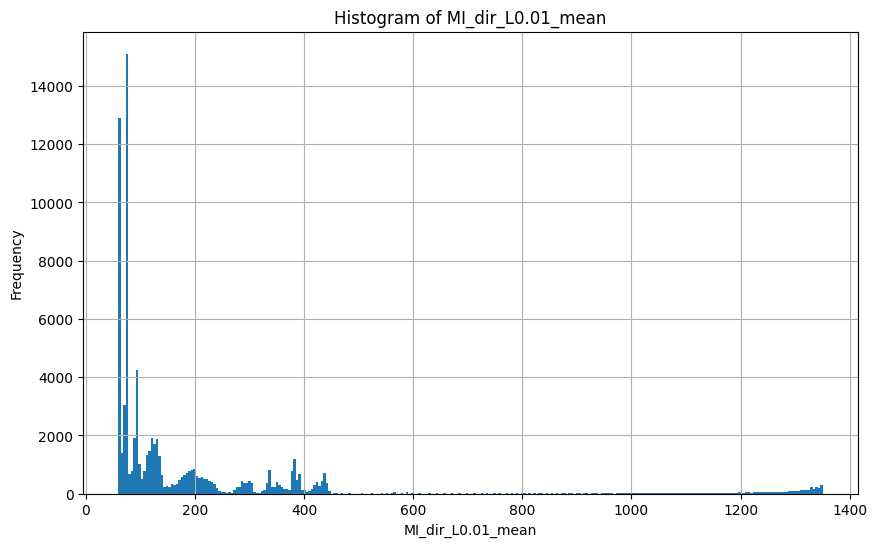

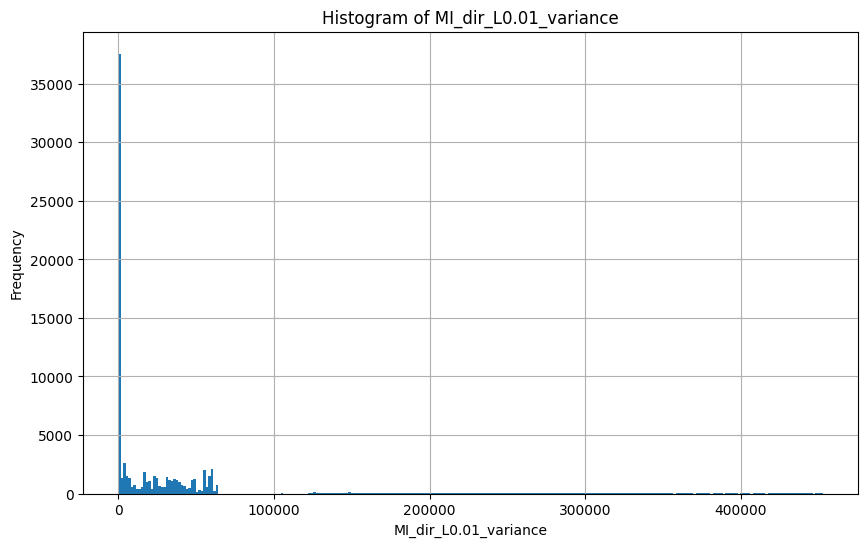

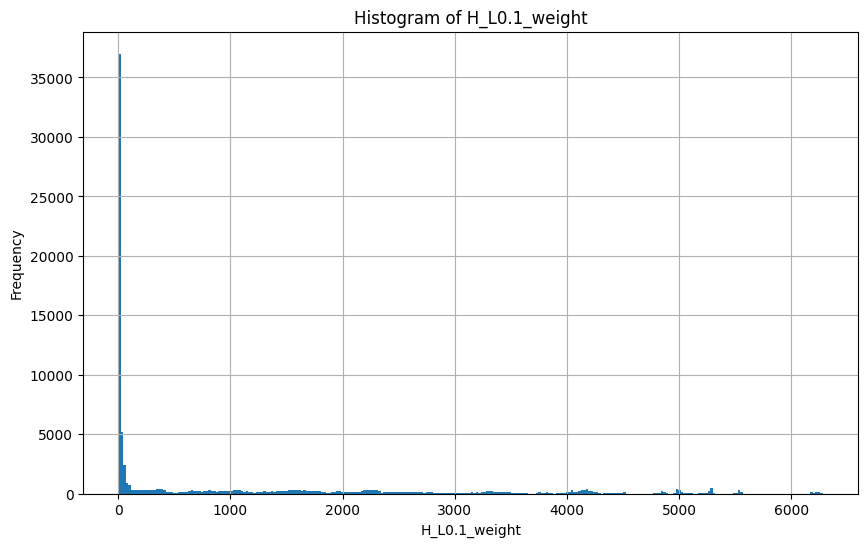

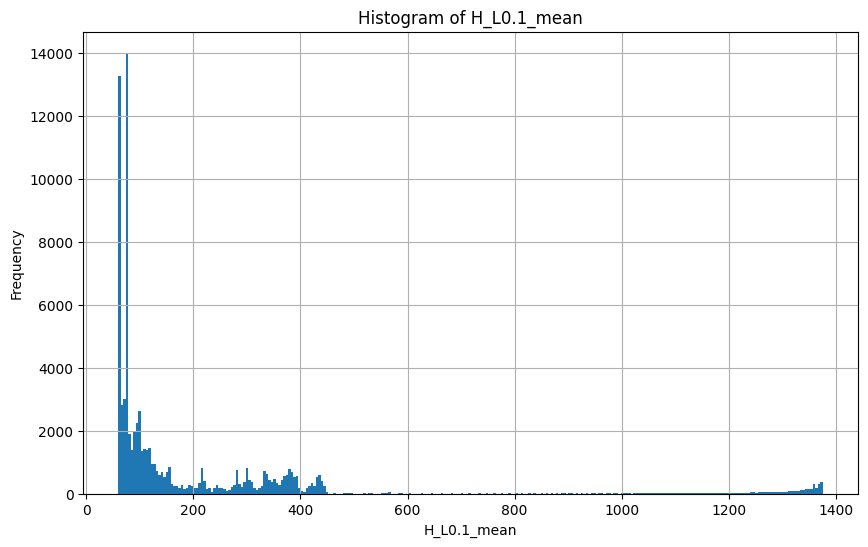

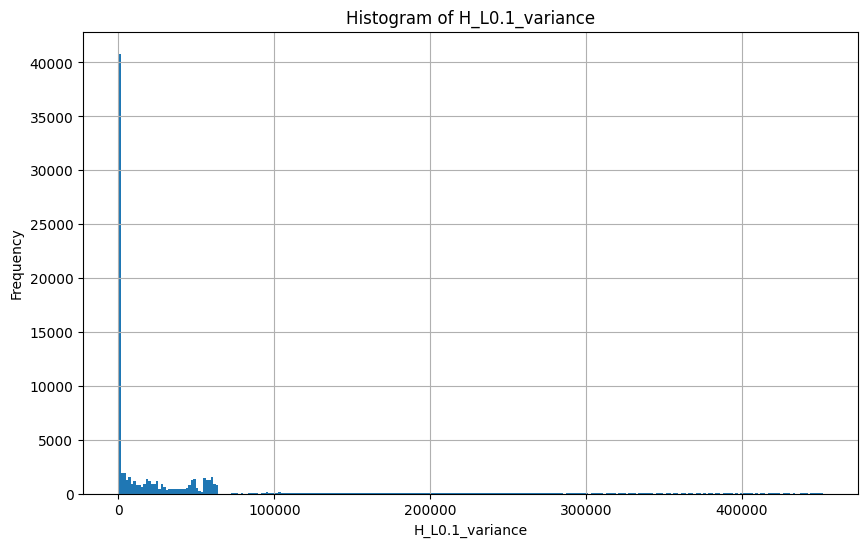

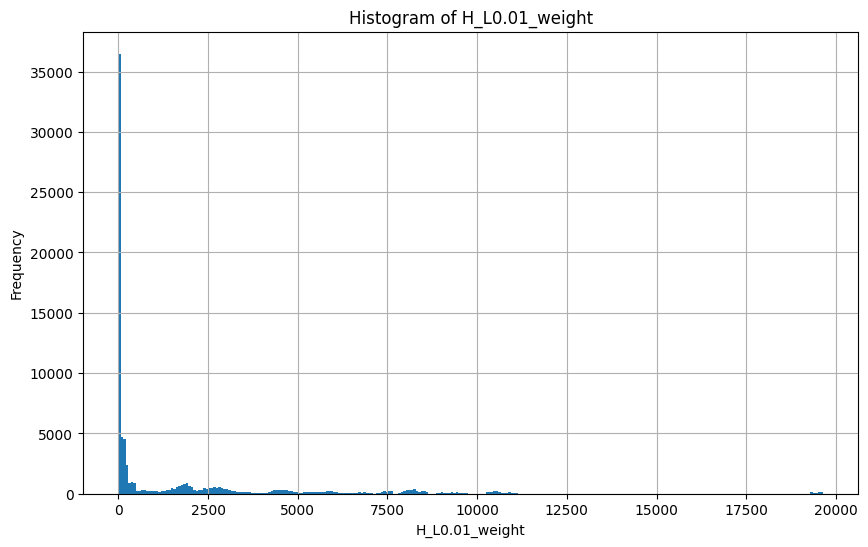

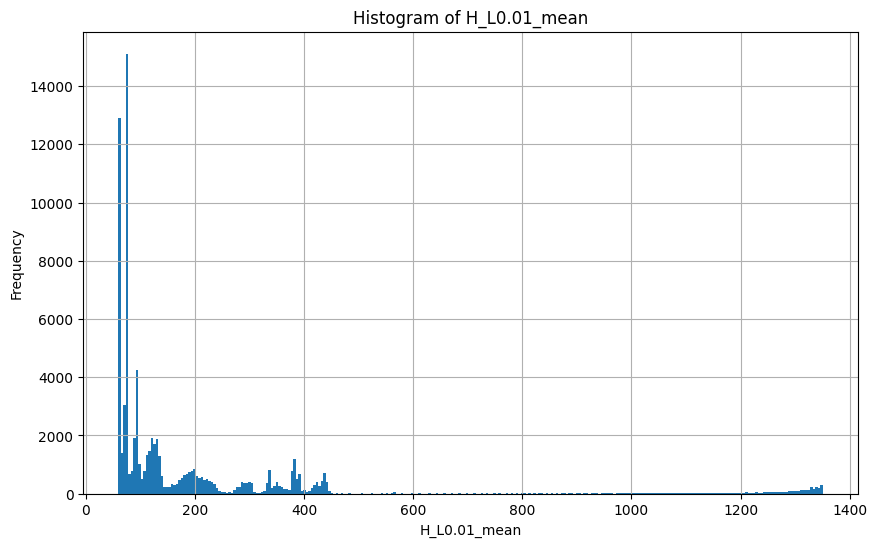

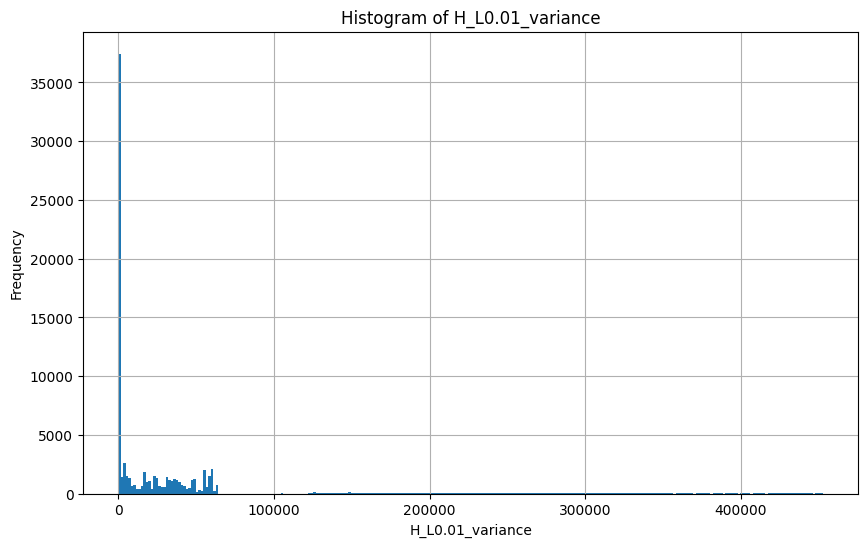

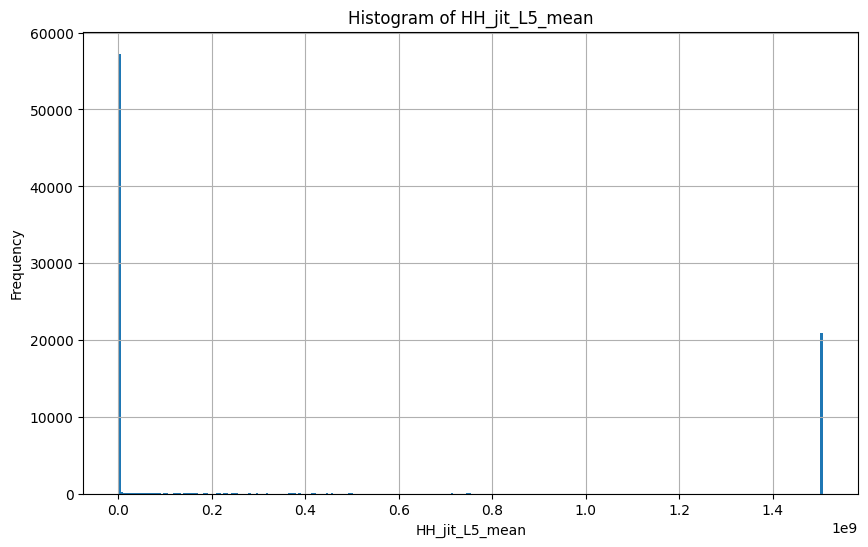

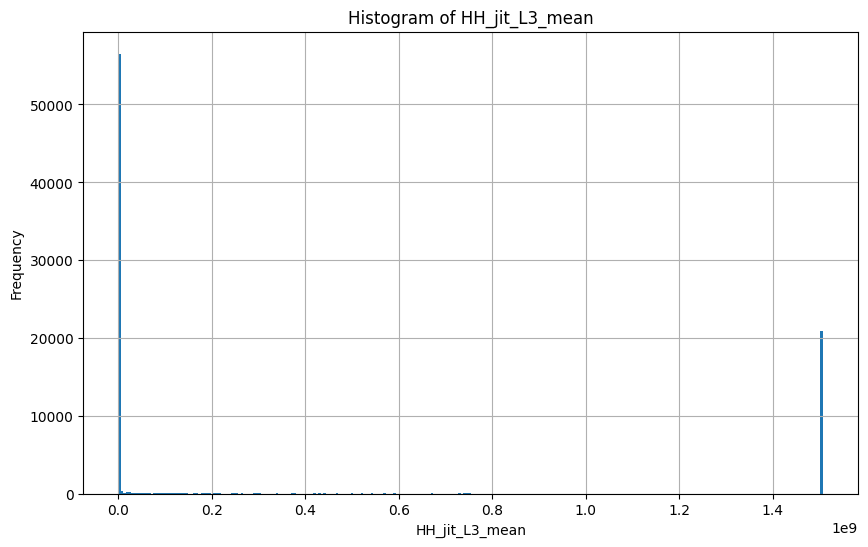

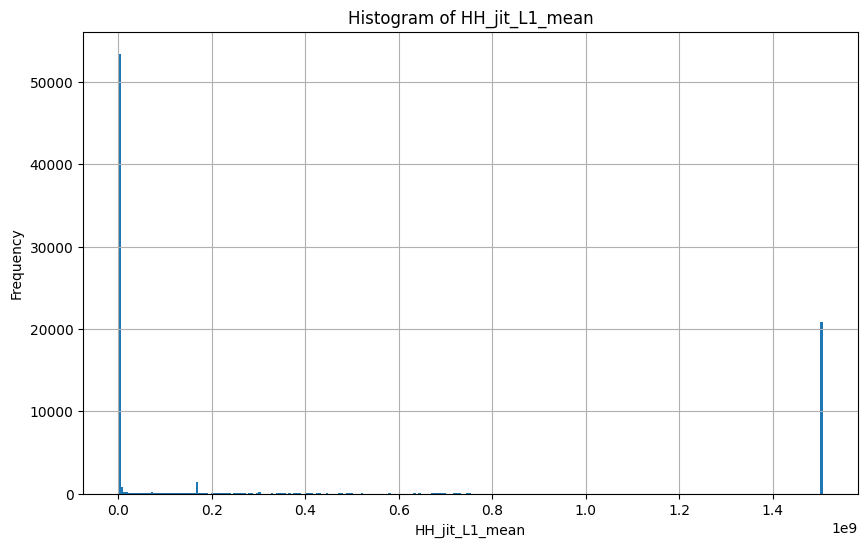

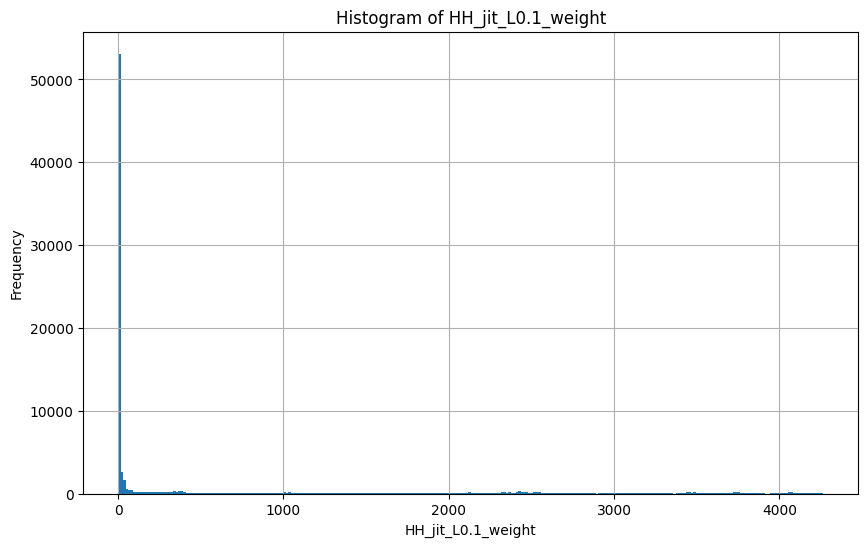

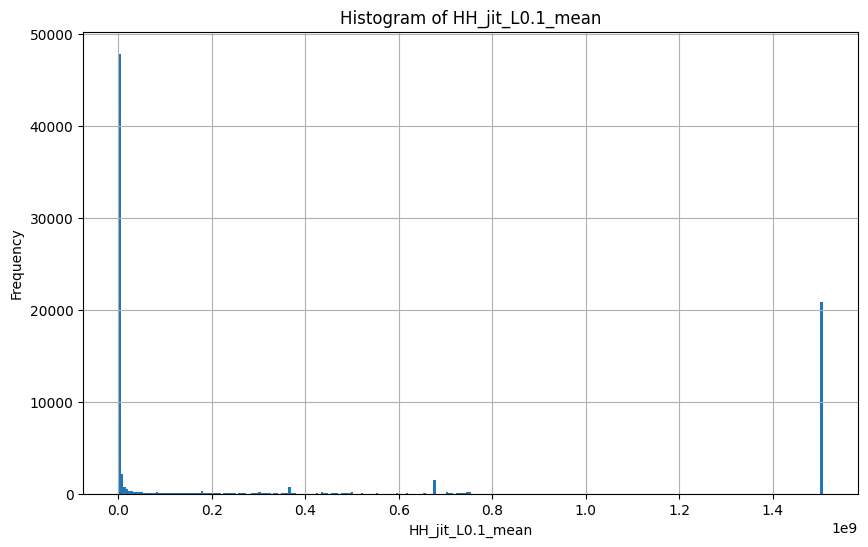

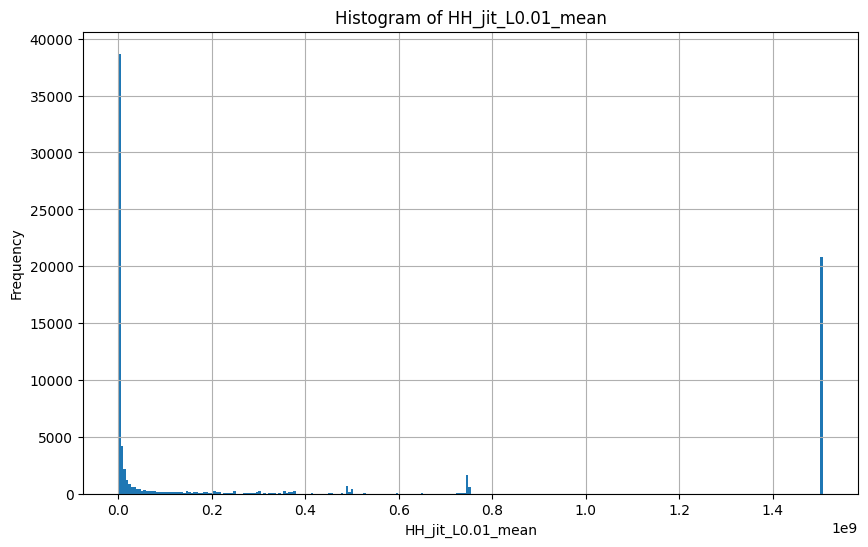

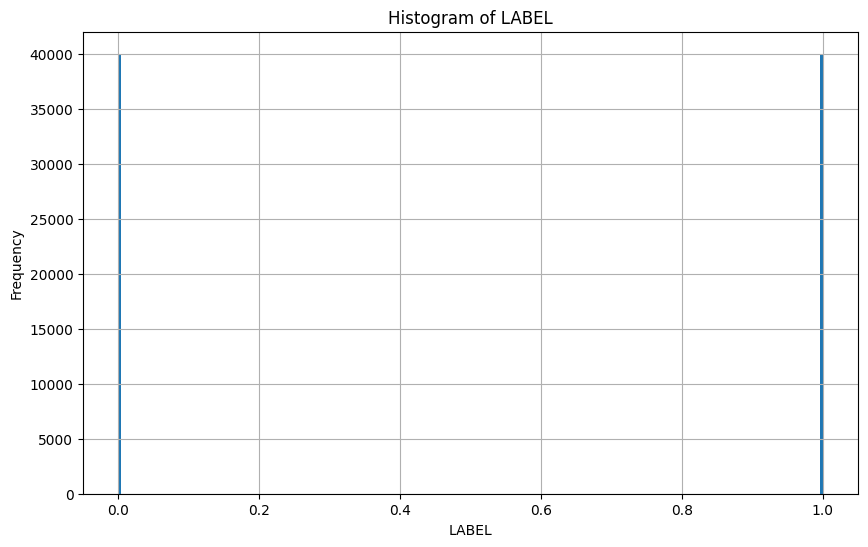

In [8]:
numerical_columns = dataset.select_dtypes(include=['number']).columns

# Calculate the number of bins using Scott's Rule
num_bins = int(len(dataset) ** 0.5)

# Set figsize based on aspect ratio and readability
figsize = (10, 6)  # You can adjust the width and height as needed

# Create histograms for each numerical column
for column in numerical_columns:
    plt.figure(figsize=figsize)
    plt.hist(dataset[column], bins=num_bins)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {column}")
    plt.grid(True)
    plt.show()

In [9]:
#Delete it ?
print(f"Original DataFrame shape: {dataset.shape}")
columns_with_single_value = dataset.columns[dataset.nunique() <= 1]
print("Columns with only one unique value (to be dropped):\n")
print(columns_with_single_value.tolist())
dataset = dataset.drop(columns=columns_with_single_value)
print("Columns with single unique value dropped.\n")
print(f"DataFrame shape after dropping these columns: {dataset.shape}")
print("\nModified DataFrame (first 5 rows):")
dataset.head()

Original DataFrame shape: (80000, 19)
Columns with only one unique value (to be dropped):

[]
Columns with single unique value dropped.

DataFrame shape after dropping these columns: (80000, 19)

Modified DataFrame (first 5 rows):


,MI_dir_L1_mean,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_jit_L5_mean,HH_jit_L3_mean,HH_jit_L1_mean,HH_jit_L0.1_weight,HH_jit_L0.1_mean,HH_jit_L0.01_mean,LABEL
0,60.000000,1.000000,60.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.505913e+09,1.505913e+09,1.505913e+09,1.000000,1.505913e+09,1.505913e+09,1
1,60.000000,1.000000,60.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.505659e+09,1.505659e+09,1.505659e+09,1.000000,1.505659e+09,1.505659e+09,0
2,74.102299,4020.903767,74.136810,5354.681027,74.129441,25.244821,4020.903767,74.136810,27.663711,5354.681027,74.129441,25.244821,1.527283e-03,7.375614e-03,1.874286e+03,4009.923449,1.892384e+05,2.633603e+05,1
3,90.000000,1.290099,87.976936,24.205671,86.189461,3837.105793,1.290099,87.976936,114.964766,24.205671,86.189461,3837.105793,4.042346e+01,4.042346e+01,4.042346e+01,1.066412,4.030084e+01,8.843831e+06,0
4,74.102723,4100.898655,74.135829,5541.152768,74.129025,24.424220,4100.898655,74.135829,26.446198,5541.152768,74.129025,24.424220,1.813740e-03,4.445933e-03,1.453555e+03,4089.271445,1.799947e+05,2.537420e+05,1


In [10]:
# Define a function for standardization
def standardize_dataframe(df):
    scaler = StandardScaler()  # Create a StandardScaler object
    
    # Extract all columns except the last one for standardization
    columns_to_standardize = df.columns[:-1]
    
    # Apply standardization to the specified columns
    df_standardized = df.copy()
    df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

    return df_standardized
# Define a function for normalization
def normalize_dataframe(df):
    scaler = MinMaxScaler()  # Create a MinMaxScaler object
    
    # Extract all columns except the last one for normalization
    columns_to_normalize = df.columns[:-1]
    
    # Apply normalization to the specified columns
    df_normalized = df.copy()
    df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])
    
    return df_normalized
def min_max_scale_dataframe(df):
    scaler = MinMaxScaler()  
    df_scaled = df.copy()
    
    # Extract all columns except the last one for scaling
    columns_to_scale = df.columns[:-1]
    
    # Apply Min-Max scaling to the specified columns
    df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
    
    return df_scaled


In [11]:
dataset = standardize_dataframe(dataset)
dataset = normalize_dataframe(dataset)
dataset = min_max_scale_dataframe(dataset)
dataset.head()

,MI_dir_L1_mean,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_jit_L5_mean,HH_jit_L3_mean,HH_jit_L1_mean,HH_jit_L0.1_weight,HH_jit_L0.1_mean,HH_jit_L0.01_mean,LABEL
0,5.551115e-17,0.000000,2.775558e-17,0.000000,9.714451e-17,0.000000,0.000000,1.387779e-17,0.000000,0.000000,1.110223e-16,0.000000,9.988420e-01,9.988420e-01,9.988420e-01,0.000000,9.988420e-01,0.998842,1
1,5.551115e-17,0.000000,2.775558e-17,0.000000,9.714451e-17,0.000000,0.000000,1.387779e-17,0.000000,0.000000,1.110223e-16,0.000000,9.986732e-01,9.986732e-01,9.986732e-01,0.000000,9.986732e-01,0.998673,0
2,1.026327e-02,0.639939,1.074307e-02,0.272625,1.094577e-02,0.000056,0.639939,1.074307e-02,0.000061,0.272625,1.094577e-02,0.000056,6.722400e-14,3.717970e-12,1.243174e-06,0.940445,1.255178e-04,0.000175,1
3,2.183318e-02,0.000046,2.126068e-02,0.001182,2.028841e-02,0.008475,0.000046,2.126068e-02,0.000254,0.001182,2.028841e-02,0.008475,2.681112e-08,2.681089e-08,2.680980e-08,0.000016,2.652525e-08,0.005866,0
4,1.026358e-02,0.652673,1.074233e-02,0.282120,1.094545e-02,0.000054,0.652673,1.074233e-02,0.000059,0.282120,1.094545e-02,0.000054,2.572387e-13,1.774803e-12,9.641116e-07,0.959059,1.193867e-04,0.000168,1


In [12]:

# Assuming dataset contains your entire dataset, where the last column is the target variable
X = dataset.iloc[:, :-1]  # Extract features (all columns except the last one)
y = dataset.iloc[:, -1]   # Extract target variable (last column)

# Replace RandomForestClassifier with any other model if desired
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Specify a threshold for feature importance
threshold = 0.01

# Create a feature selector based on importance scores
feature_selector = SelectFromModel(clf, threshold=threshold, prefit=True)

# Transform the dataset to select important features
X_selected = feature_selector.transform(X)

# Get the indices of selected features
selected_indices = feature_selector.get_support(indices=True)

# Get the names of all features
feature_names = X.columns

# Get the names of selected features
selected_feature_names = np.array(feature_names)[selected_indices]

# Print the names of selected features
print("Names of selected features:", selected_feature_names)


Names of selected features: ['MI_dir_L0.1_weight' 'MI_dir_L0.1_mean' 'MI_dir_L0.01_weight'
 'MI_dir_L0.01_mean' 'MI_dir_L0.01_variance' 'H_L0.1_weight' 'H_L0.1_mean'
 'H_L0.1_variance' 'H_L0.01_weight' 'H_L0.01_mean' 'H_L0.01_variance'
 'HH_jit_L5_mean' 'HH_jit_L3_mean' 'HH_jit_L1_mean' 'HH_jit_L0.1_mean'
 'HH_jit_L0.01_mean']


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [17]:
import time
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load and prepare your dataset
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Record the start time
start_time = time.time()

# Train the model
model_nn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Calculate the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time} seconds')

# Evaluate the model
loss, accuracy = model_nn.evaluate(X_test, y_test)
print(f'Global Model Testing Accuracy: {accuracy}')

# Predict probabilities for the test data
y_pred_probs = model_nn.predict(X_test).ravel()

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f'ROC AUC: {roc_auc}')


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step - accuracy: 0.9714 - loss: 0.1225
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.9871 - loss: 0.0370
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.9876 - loss: 0.0330
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.9891 - loss: 0.0284
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.9913 - loss: 0.0245
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - accuracy: 0.9920 - loss: 0.0226
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.9939 - loss: 0.0201
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.9942 - loss: 0.0199
Epoch 9/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.9944 - loss: 0.0186
Epoch 10/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 659us/step - accuracy: 0.9945 - loss: 0.0182
Training Time: 15.372974395751953 seconds
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.

Epoch 1/10


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.9663 - loss: 0.1309
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - accuracy: 0.9871 - loss: 0.0375
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.9875 - loss: 0.0349
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.9902 - loss: 0.0284
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - accuracy: 0.9911 - loss: 0.0261
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step - accuracy: 0.9921 - loss: 0.0239
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 728us/step - accuracy: 0.9931 - loss: 0.0229
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step - accuracy: 0.9946 - loss: 0.0177
Epoch 9/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - accuracy: 0.9946 - loss: 0.0187
Epoch 10/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - accuracy: 0.9947 - loss: 0.0187
Training Time: 17.266527891159058 seconds
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.9960 - loss

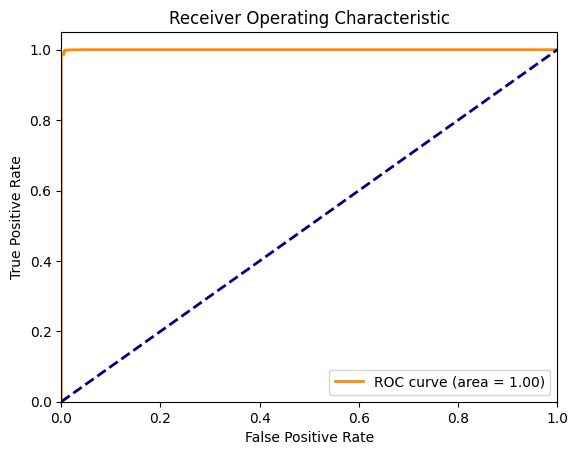

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load and prepare your dataset
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Record the start time
start_time = time.time()

# Train the model
model_nn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Calculate the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time} seconds')

# Evaluate the model
loss, accuracy = model_nn.evaluate(X_test, y_test)
print(f'Global Model Testing Accuracy: {accuracy}')

# Predict probabilities for the test data
y_pred_probs = model_nn.predict(X_test).ravel()
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate confusion matrix, precision, and recall
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f'ROC AUC: {roc_auc}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
